In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from cue.utils.plotting import row_height, save_tight_fig, single_fig_size, style, textwidth

In [4]:
style()

# Differentiator

In [5]:
class Differentiator(object):
    def __init__(self, tau1, tau2):
        assert tau1 < tau2
        self.tau1 = tau1
        self.tau2 = tau2
        
    def h1(self, t):
        assert np.all(t >= 0.)
        return np.exp(-t / self.tau1) / self.tau1
    
    def h2(self, t):
        assert np.all(t >= 0.)
        return np.exp(-t / self.tau2) / self.tau2
    
    def __call__(self, x, t):
        t_long = np.arange(0., 100. * max(self.tau1, self.tau2), t[1] - t[0])
        a = self.h1(t)
        a /= np.sum(a) * (t_long[1] - t_long[0])
        b = self.h2(t)
        b /= np.sum(b) * (t_long[1] - t_long[0])
        return np.convolve(x(t), a - b, 'full')[:len(t)]
    
    def mag_response(self, ω):
        return ω * (self.tau2 - self.tau1) / np.sqrt(
            1. + (self.tau1 * self.tau2 * ω**2)**2 + ω**2 * (self.tau1**2 + self.tau2**2))

In [6]:
class UnitStep(object):
    def __init__(self, step_t):
        self.step_t = step_t
        
    def __call__(self, t):
        return np.asfarray(t >= self.step_t)

In [7]:
t = np.linspace(0., .6, 300)
u = UnitStep(0.1)
diff = Differentiator(0.005, 0.05)
y = diff(u, t)

In [8]:
f = np.logspace(-2, 3)
ω = 2. * np.pi * f

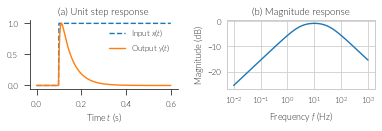

In [9]:
fig = plt.figure(figsize=(textwidth, 0.85 * row_height))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, u(t), '--', label="Input $x(t)$")
ax1.plot(t, y / np.max(y), label="Output $y(t)$")
ax1.set_title("(a) Unit step response")
ax1.set_xlabel("Time $t$ (s)")
ax1.legend(loc='best')
sns.despine(ax=ax1)

with sns.axes_style('whitegrid'):
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(f, 10 * np.log10(diff.mag_response(ω)))
    ax2.semilogx()
    ax2.set_title("(b) Magnitude response")
    ax2.set_xlabel("Frequency $f$ (Hz)")
    ax2.set_ylabel("Magnitude (dB)")

fig.tight_layout()

In [10]:
save_tight_fig(fig, '../../../phd-thesis/figures/differentiator.pdf')

# Integrator

In [11]:
def u(t):
    if t < 1.:
        return 0.
    elif t < 3.:
        return 0.2
    elif t < 4.:
        return 0.
    elif t < 5.:
        return 0.4
    else:
        return 0.

In [12]:
tau = 0.1
with nengo.Network(seed=1) as model:
    ens = nengo.Ensemble(100, 1)
    u_node = nengo.Node(u)
    nengo.Connection(u_node, ens[0], transform=tau)
    c = nengo.Connection(ens, ens, synapse=tau)
    p_u = nengo.Probe(u_node)
    p_ens = nengo.Probe(ens[0], synapse=0.01)

In [13]:
with nengo.Simulator(model) as sim:
    sim.run(10.)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:02.                                                                                         


In [14]:
from nengo.builder.ensemble import get_activities

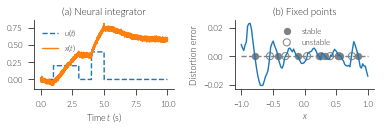

In [15]:
fig = plt.figure(figsize=(textwidth, 0.85 * row_height))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(sim.trange(), sim.data[p_u], '--', label="$u(t)$")
ax1.plot(sim.trange(), sim.data[p_ens], label="$x(t)$")
ax1.legend(loc='best')
ax1.set_title("(a) Neural integrator")
ax1.set_xlabel("Time $t$ (s)")

x = np.linspace(-1., 1., 100)
y = get_activities(sim.data[ens], ens, np.atleast_2d(x).T) @ np.squeeze(sim.data[c].weights) - x
assert np.all(np.sign(y) != 0.), "Zeros not handled correctly"
crossings = np.diff(np.sign(y))
interp = x[:-1] + 0.5 * np.diff(x)
stable = interp[crossings < 0]
unstable = interp[crossings > 0]

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x, np.zeros_like(x), '--', c='gray')
ax2.plot(x, y)
ax2.scatter(stable, np.zeros_like(stable), c='gray', s=50, label="stable")
ax2.scatter(
    unstable, np.zeros_like(unstable), marker='o', edgecolors='gray', s=50,
    facecolors='none', lw=1, label="unstable")
ax2.legend(loc='best')
ax2.set_title("(b) Fixed points")
ax2.set_xlabel("$x$")
ax2.set_ylabel("Distortion error")

sns.despine(fig)
fig.tight_layout()

In [16]:
save_tight_fig(fig, '../../../phd-thesis/figures/integrator.pdf')

# Thresholding ensemble

In [17]:
with nengo.Network(seed=1) as model:
    with nengo.presets.ThresholdingEnsembles(0.):
        ens = nengo.Ensemble(25, 1, neuron_type=nengo.LIFRate())
        
    inp = nengo.Node(lambda t: t / 10. - 1.)
    nengo.Connection(inp, ens, synapse=None)
    
    rect = nengo.Node(size_in=1)
    nengo.Connection(ens, rect, synapse=None, function=lambda x: x if x > 0. else 0.)
    
    heavi = nengo.Node(size_in=1)
    nengo.Connection(ens, heavi, synapse=None, function=lambda x: x > 0.)
    
    p_inp = nengo.Probe(inp)
    p_rect = nengo.Probe(rect)
    p_heavi = nengo.Probe(heavi)

In [18]:
with nengo.Simulator(model) as sim:
    sim.run(20.)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:03.                                                                                         


In [19]:
from nengo.utils.ensemble import tuning_curves
from matplotlib import gridspec

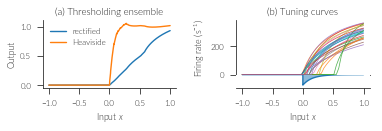

In [20]:
fig = plt.figure(figsize=(textwidth, 0.85 * row_height))

gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(plt.Subplot(fig, gs[0]))
ax1.plot(sim.data[p_inp], sim.data[p_rect], label='rectified')
ax1.plot(sim.data[p_inp], sim.data[p_heavi], label='Heaviside')
sns.despine(ax=ax1)
ax1.set_title("(a) Thresholding ensemble")
ax1.set_xlabel("Input $x$")
ax1.set_ylabel("Output")
ax1.legend(loc='best')

gs_inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0., height_ratios=(4., 1.))
ax2 = fig.add_subplot(plt.Subplot(fig, gs_inner[0]))
ax2.plot(*tuning_curves(ens, sim), lw=.75, alpha=0.8);
ax2.set_ylim(bottom=0.)
sns.despine(ax=ax2)
ax2.xaxis.set_visible(False)
ax2.set_title("(b) Tuning curves")
ax2.set_ylabel("Firing rate ($\mathrm{s}^{-1}$)")

ax3 = fig.add_subplot(plt.Subplot(fig, gs_inner[1], sharex=ax2))
x = np.linspace(0., 1., 100)
y = -1. / 0.15 * np.exp(-x / 0.15)
x = np.concatenate(((-1., 0.), x))
y = np.concatenate(((0., 0.), y))
ax3.fill_between(x, y, alpha=0.5)
ax3.plot(x, y)
ax3.set_ylim(top=0., bottom=1.3 * np.min(y))
sns.despine(ax=ax3, left=True)
ax3.yaxis.set_visible(False)
ax3.set_xlabel("Input $x$")

fig.tight_layout()

In [21]:
save_tight_fig(fig, '../../../phd-thesis/figures/thresholding.pdf')